# Crude image registration

In [1]:
import sys
sys.path.append('..')
from faimed3d.basics import *
from faimed3d.augment import *
from fastai.basics import *
import torchvision.transforms.functional as _F


In this notebook, I will try to adapt spacing, origin and direction in three MRI sequences of the same examination. 

In [2]:
path = Path('/media/ScaleOut/prostata/data/dcm/A0001047141')

In [3]:
t1 = TensorDicom3D.create(path/'T1_map/DICOM')
t2 = TensorDicom3D.create(path/'T2/DICOM')
adc = TensorDicom3D.create(path/'ADC/DICOM')

I will use proprietary patient data from a research project, which cannot be uploaded to GitHub, so the code in this Notebook cannot be tested in the repositories CI. 

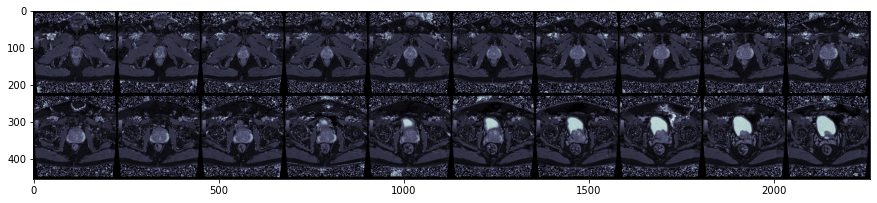

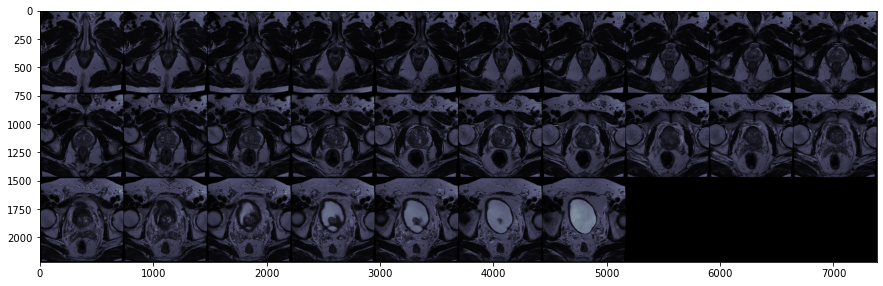

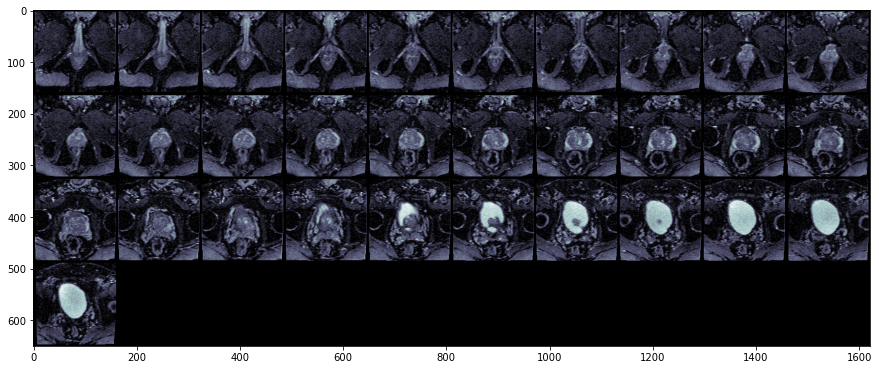

In [4]:
t1.show()
t2.show()
adc.show()

In this research project, I build a 4D CNN for prostate segmentation and cancer detection in multiparametric MRI. Four sequences are of importance for this task: axial T1 map, axial T2w, axial DWI and ADC. As ADC is derived from DWI, spacing, orientation and direction should be the same. Thus only one of the sequences is loaded. The images are not preprocessed. 
ADC usually has a very low spatial resolution while T2w images can have a very high reolution. 

In [5]:
t1.size(), t2.size(), adc.size()

((20, 224, 224), (27, 736, 736), (31, 160, 160))

SimpleITK and PyTorch follow different conventions. While PyTorch refers to axis in a 3d Volume as Depth x Height x Width, SimpleITK refers to the axis as  Width x Height x Depth ([see here](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/03_Image_Details.html)). Also the pixel with id (0,0) in a SimpleITK image is the left lowerhand pixel, while in PyTorch it is the left upper hand pixel. 

## Origin
In SimpleITK images are seem as objects that occupy physical space, so the image itself is inside a physical coordinate system. The origin of that coordiante systems usually is not identical to the left lower pixel but can be at any location of the pixel array (or even outside the array). `TensorDicom3D.get_origin()` returns the coordinates of the lower lefthand pixel of the image in that coordiante system. 

In [6]:
t1.get_origin(), t2.get_origin(), adc.get_origin()

((-126.491, -100.798, -52.8797),
 (-89.1169, -51.0127, -94.2619),
 (-87.4231, -50.3325, -100.934))

Looking at the above images, the field of view in T1 is much larger than for T2 and ADC (the trochanter major is seen on the T1 images but not on T2 and ADC). Given the negative coordinates of the origins, the origin of the grid seems to be in the middle of the image (probably somewhere in the prostate).  
It is important to note, that the values given are mm, not pixels.

## Direction
Direction gives the direction cosine matrix for the pixel. 

In [7]:
t1.get_direction(), t2.get_direction(), adc.get_direction()

((1.0, -4.897e-12, 0.0, 4.897e-12, 1.0, 0.0, 0.0, 0.0, 1.0),
 (1.0,
  -4.896998150404149e-12,
  4.828098176428677e-16,
  4.651171271894722e-12,
  0.9497696412720743,
  -0.31294988179885197,
  1.5320564342308695e-12,
  0.31294988179885197,
  0.9497696412720743),
 (1.0,
  -4.897001193886589e-12,
  2.1432805225291114e-16,
  4.652459113303211e-12,
  0.950049231621556,
  -0.3121000760898518,
  1.5281508230227414e-12,
  0.3121000760898518,
  0.950049231621556))

Seems like in this case, we are unlucky and the direction does not remain the same across all sequences. Meaning the technical assistant use a different angulation for the sequences.
Small differences in direction may be ignored, but in this case the angulation is to pronunced and we'll have to adapt the origin before further processing the images. 

## Spacing
Spacing gives the distance between to centers in a pixel

In [8]:
t1.get_spacing(), t2.get_spacing(), adc.get_spacing()

((1.25446, 1.25446, 3.000002105263158),
 (0.271739, 0.271739, 2.9999989413237773),
 (1.25, 1.25, 2.999986284598277))

When processing multiple 3D images, we want the Spacing, orientation and direction of all pixles to be the same (ot as similar as possible). 
Smaller spacing, means higher resolution of the image (larger image), larger spacing means smaller resolution.  
The best approach would probably be to downsacle the large images to fit the small images. 

## Identify the Origin
The goal is to align all images, so that the point of origin overlapps. 
To help with visualization, first a crude function, to highlight a certain point in a tensor is defined. 

In [9]:
@patch
def draw_point(x:TensorDicom3D, d:int,h:int,w:int):
    t = x.clone() # avoid overwriting the pixel values of source tensor
    sz_l = x.shape[1] // 20
    sz_w = x.shape[1] // 60
    
    t[d,h-sz_l:h+sz_l,w-sz_w:w+sz_w] = t.max()
    t[d,h-sz_w:h+sz_w,w-sz_l:w+sz_l] = t.max()
    return t

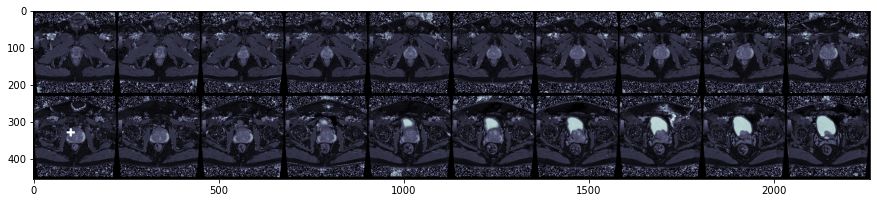

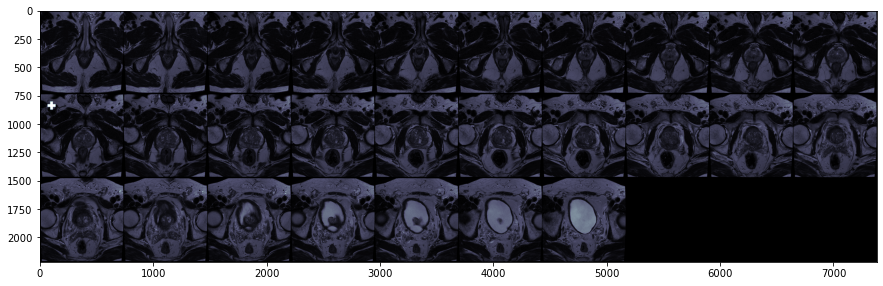

In [10]:
t1.draw_point(10, 100, 100).show()
t2.draw_point(10, 100, 100).show()

As image spacing and origin do not match in the above images, the point is not placed at the same position inside the patient. 

### Plot the origin
In SimpleITK the, lower left pixel of a 2D array has the coordinates 0,0. This differs from PyTorch, where 0,0 are the coordinates of the left upper pixel. 
`get_origin` returns the physical ids of the left lower pixel/voxel in the image. One could also interpret this as walking directions. Assuming `get_origin` returns `(-10, 11, 20)` this means one has to walk -10 mm up the width dimension, 11 mm down the width height and 20 mm up the depth dimension. If the ID of the origin is unknown and only the ID of the lower left pixel is know, the walking directions can just be reverted. 
However, in PyTorch one would start at the uper left pixel, so to reach the lower left pixel one first would have to walk down the whole length of the height dimension (H) to then again walk up 11 mm (which is equal to walk down H - 11 mm).  
To implement this in code, the physical dimension has to be converted to px by dividing the values by the pixel spacing. 

In [11]:
left_lwr = tuple(map(operator.truediv, t1.get_origin(), t1.get_spacing()))
left_lwr

(-100.83302775696316, -80.3517051161456, -17.62655429715488)

`left_lwr` now gives the walking directions from the origin to the left lower pixel in px. Inverting `left_lwr` will give the walking instructions to the `origin`

In [12]:
origin = tuple(map(operator.mul, left_lwr, (-1,-1,-1)))
origin

(100.83302775696316, 80.3517051161456, 17.62655429715488)

Now the subtracting the height-value from the image heigt, will yield the walking instructions from the left upper pixel. Finally floats are cast to integers, to enable indexing. 

In [13]:
d,h,w = origin
h = t1.shape[1]-h
origin = int(round(w)),int(round(h)),int(round(d))

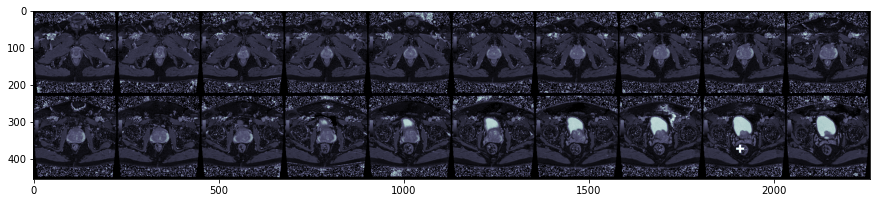

In [14]:
t1.draw_point(*origin).show()

Summarizing the above steps will give the follwing function. 

In [15]:
@patch
def get_origin_px_id(x:TensorDicom3D): 
    D,H,W = x.size()
    w,h,d = tuple(map(lambda a,b: int(round(a/b))*-1, x.get_origin(), x.get_spacing()))
    return d,H-h,w

In [16]:
t1.get_origin_px_id()

(18, 144, 101)

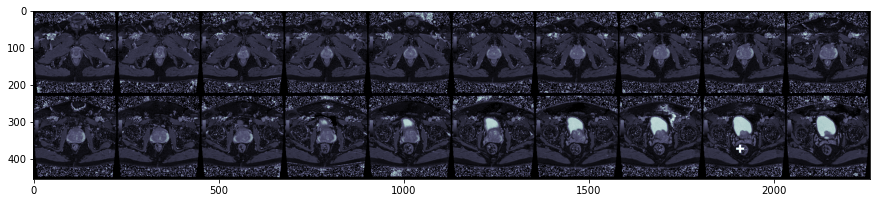

In [17]:
t1.draw_point(*t1.get_origin_px_id()).show()

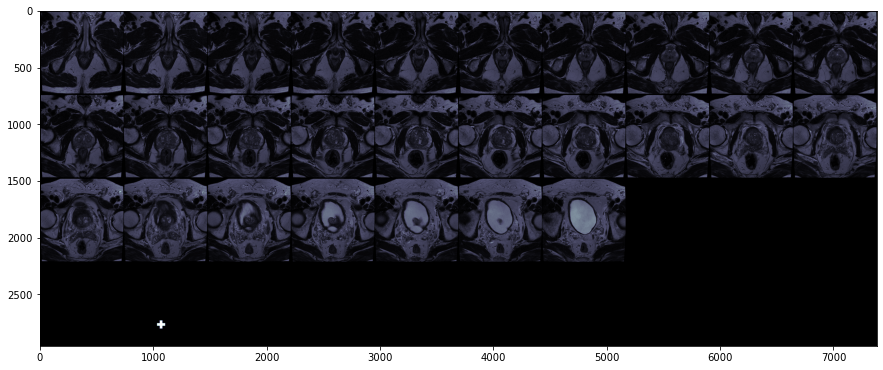

In [18]:
F.pad(t2, (0,0,0,0,0,5)).draw_point(*t2.get_origin_px_id()).show()

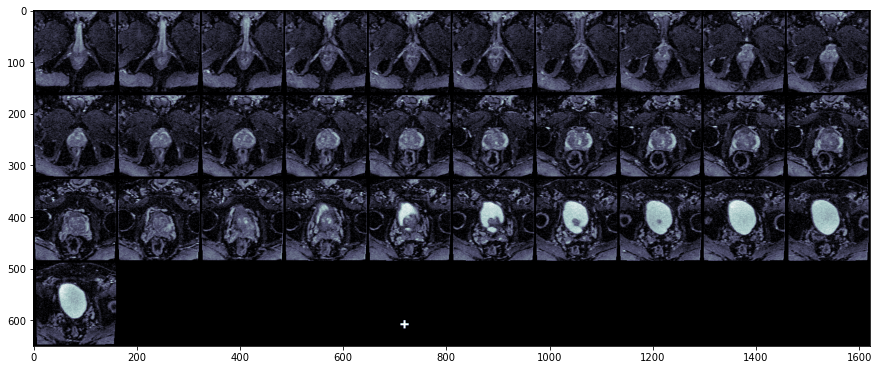

In [19]:
F.pad(adc, (0,0,0,0,0,5)).draw_point(*adc.get_origin_px_id()).show()

It appears, the origin of T2 and ADC is roughly at the same place but outside the image area. It also seems to be at the same place, as in the T1 (remember the T1 is angulated). There might be small differences because of casting the pixel-ID to int, but those are probably not as important

### Get px ID of any point 

For a more general approach, it would be usefull to give any coordinate from the real world and recieve the ID of the pixel on that coordinate.
To get the px id of a physical point, first the origin is needed. 
The physical point is translated to px using the spacing and will now give the walking instructions to reach it, if starting from the origin. So walking to the origin and then to the point is the same as addint both paths together. 

In [20]:
@patch
def get_px_of_physical_point(x:TensorDicom3D, point:tuple): 
    d,h,w = x.get_origin_px_id()
    ph,pw,pd = tuple(map(lambda a,b: int(round(a/b)), point, x.get_spacing()))
    D,H,W = x.size() # h+ph needs to be subtracted from H as SimpleITK takes the lwr_left corner as 0,0,0
    return d+pd,h-ph,w+pw

## Get the physical ID of any point
Again, the origin is the staring point. The distance between the pixel and the origin will be the coordiante on the physical coordinate system.  The distance (`px_dist`) is calculated by subtracting the two points. Also the h-distance has to be inverted (since the lower left pixel in SimpleITK corresponds to the upper right pixel in PyTorch). The order of the `px_dist` is then inverted from D x H x W to W x H x D to match the SimpleITK convention. Finally the distances can be scaled using pixel spacing. 


In [21]:
@patch
def get_physical_point_of_px(x:TensorDicom3D, point:tuple): 
    px_dist= tuple(map(operator.sub, point, x.get_origin_px_id()))  
    px_dist = px_dist[::-1]
    pw, ph, pd = tuple(map(operator.mul, px_dist, x.get_spacing()))
    return ph*-1, pw, pd # the last dim swap is necessary, but why?

Testing the functions

In [22]:
adc_orig = t1.get_px_of_physical_point(adc.get_origin())
adc_orig # negativer value mean, the dimension of this pixel is not within the FOV of the t1 image

(-16, 214, 61)

In [23]:
t1.get_physical_point_of_px(adc_orig), adc.get_origin()

((-87.81219999999999, -50.178399999999996, -102.00007157894737),
 (-87.4231, -50.3325, -100.934))

In [24]:
pt = (-124.0312489271172, 6245.42856979370241, 12345.00000110538292)
adc_orig = t1.get_px_of_physical_point(pt)
t1.get_physical_point_of_px(adc_orig), pt

((-124.19153999999999, 6245.95634, 12345.008663157896),
 (-124.0312489271172, 6245.428569793702, 12345.000001105383))

## Correct for Direction
In theory, if we rotate the image, this would change the position of the pixels in the physical coordinate system. However, when we read the images as Tensor, we already rotate the image (as all images are displayed as axial images). So applying rotation to the image, basically corrects the prevoius rotation. Still we need to calculate the correct rotation angle (for all three axis). For the current example we know, that T2 and ADC have the same direction, so only T1 should be corrected.
`TensorDicom3D.get_direction()` yields the direction cosine matrix (dcm) for the image.  
Following SimpleITK's convetions, it should give coordinates as follows: 

```
          w       h       d

   W     W_w  |  W_h  |  W_d
         --------------------
   H     H_w  |  H_h  |  H_d
         --------------------
   D     D_w  |  D_h  |  D_d

```

here `W` refers to the vector giving the direction of the Width dimension and `w,h,d` beeing the values of that vector. The direction of the dimension along itself is alway one, so the matrix can be simplfied to: 

```
          w       h       d

   W       1  |  W_h  |  W_d
         --------------------
   H     H_w  |   1   |  H_d
         --------------------
   D     D_w  |  D_h  |  1

```
However, `TensorDicom3D.get_direction()` returns a 9-value tuple, which first needs to be converted to a matrix. 


In [25]:
dcm = tensor(t1.get_direction()).view(3,3)
dcm

tensor([[ 1.0000e+00, -4.8970e-12,  0.0000e+00],
        [ 4.8970e-12,  1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [26]:
def rotate(x:TensorDicom3D, *args, **kwargs):
    return _F.rotate(x.unsqueeze(0), *args, **kwargs).squeeze()

In [27]:
import math
def angle_from_dcm(dcm):
    angle_H = math.atan2(dcm[0, 1], dcm[0, 2])*180/math.pi
    angle_W = math.atan2(dcm[1, 0], dcm[0, 2])*180/math.pi
    angle_D = math.atan2(dcm[2, 0], dcm[0, 1])*180/math.pi
    return angle_H, angle_W, angle_D

In [28]:
dcm_t1 = tensor(t1.get_direction()).view(3,3)
t1_angles = angle_from_dcm(dcm_t1)
t1_angles

(-90.0, 90.0, 180.0)

Given the DCM of the T1 map beeing a quasi identity matrix and the angles beeing -90, 90, 180, the T1 seems to be angulated strictly ortogonal to the axis of the physical coordiante system. So, T2 and ADC must be the rotated sequences.  

In [29]:
dcm_t2 = tensor(t2.get_direction()).view(3,3)
t2_angles = angle_from_dcm(dcm_t2)
to_rotate = tuple(map(operator.sub, t1_angles, t2_angles))
to_rotate

(-0.005648963917820993, 0.005947526705838868, 17.372617309945838)

It might be usefull, to go with slightly less accuracy while calculating the angles, so we round the angles. 

In [30]:
to_rotate = tuple([round(i) for i in to_rotate])
to_rotate

(0, 0, 17)

The rotation angles, give the number of degrees to rotate the image in the physical space, given the pixel spacing is valid. However, when loading 3D images into PyTorch the pixel spacing is discarded and the angles are not correct anymore. We need to recalculate the angles as if the pixel size was 1 x 1 x 1 mm. 
In `faimed3d` a rotation of a 3D volume happens slicewise. This means the tensor is unbund into a list of slices, each slice is rotated and the tensor is then stacked again. Rotating is the axial plane is equivalent to rotating along the D dimension, rotation along the coronal plane is equivalent to rotating along the H dimension and rotating along the sagittal plane is equivalent to rotating along the W axis. So angles have to be corrected only for the plane they are rotated by. 


In [31]:
@patch
def rotate_3d_volume(x:(TensorDicom3D, TensorMask3D), angles_to_rotate):
    # angles are in order W, H, D
    # Tensor axis are D, H, W
    
    m = x._metadata
    sp_w, sp_h, sp_d = x.get_spacing()
    
    px_sz = x.get_spacing()[0]
    
    f = lambda a,b: a/b if b > 1 else a*b
    
    angles_to_rotate = tuple(map(f, angles_to_rotate, (sp_w, sp_h, sp_d)))
    angles_to_rotate = tuple(map(f, angles_to_rotate, (sp_h, sp_d, sp_w, )))
    
    x = x.apply_along_dim(partial(rotate, angle = angles_to_rotate[2], expand=True),dim=2)
    x = x.apply_along_dim(partial(rotate, angle = angles_to_rotate[1], expand=True),dim=1)
    x = x.apply_along_dim(partial(rotate, angle = angles_to_rotate[0], expand=True),dim=0)
    
    x._metadata = m
    return x

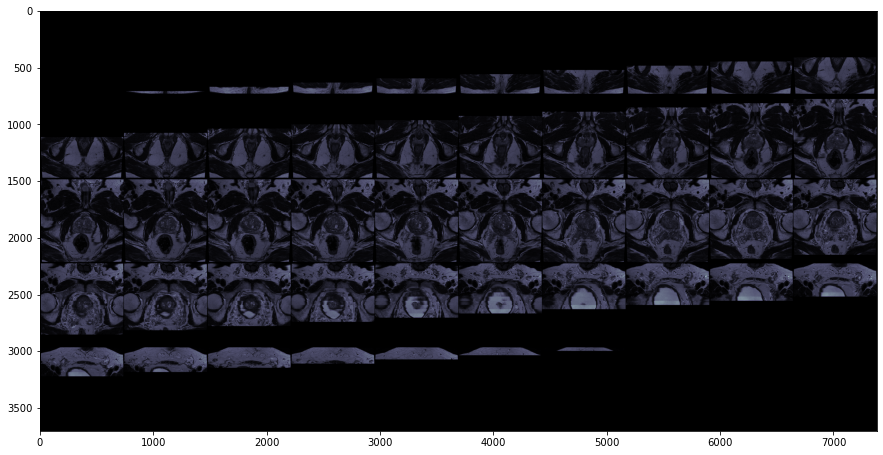

In [32]:
t2_rot = t2.rotate_3d_volume(to_rotate)
t2_rot.show()

In [34]:
dcm_adc = tensor(adc.get_direction()).view(3,3)
adc_angles = angle_from_dcm(dcm_adc)
to_rotate = tuple(map(operator.sub, t1_angles, adc_angles))
to_rotate = tuple([round(i) for i in to_rotate])
to_rotate

(0, 0, 17)

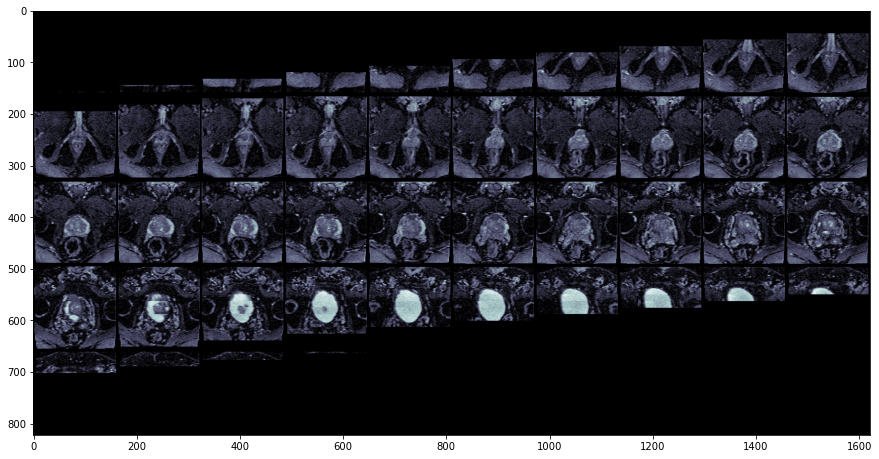

In [35]:
adc_rot = adc.rotate_3d_volume(to_rotate)
adc_rot.show(axis = 0)

the rotations look reasonable and similar across the two volumes. 

## Adapt pixel spacing across images

In [36]:
from faimed3d.augment import *

The highest pixel spacing value is equal to the lowest resolution. Upscaling can blur images and most volumes will get downscaled before training. So, it might be the best to adapt all images to the one with the lowest resolution.  Therefore, the max spacing value for each dimension acorss all images is first searched. 

In [37]:
w_sp, h_sp, d_sp = [],[],[]
for item in [t1, t2_rot, adc_rot]:
    w,h,d = item.get_spacing()
    w_sp.append(w)
    h_sp.append(h)
    d_sp.append(d)
    
w_sp = max(w_sp)
h_sp = max(h_sp)
d_sp = max(d_sp)
new_spacing = (w_sp, h_sp, d_sp)
new_spacing

(1.25446, 1.25446, 3.000002105263158)

In [38]:
t1.get_spacing(), t2_rot.get_spacing(), adc_rot.get_spacing()

((1.25446, 1.25446, 3.000002105263158),
 (0.271739, 0.271739, 2.9999989413237773),
 (1.25, 1.25, 2.999986284598277))

It seems like the T1 map hat highest spacing values for all dimension. However it might not always be the case, that one image has the lowest resolution across all dimensions. 

In [39]:
t1.size(), t2_rot.size(), adc_rot.size()

((20, 224, 224), (48, 738, 736), (44, 162, 160))

In [40]:
@patch
def calc_new_size(x:TensorDicom3D, new_spacing):
    rescale_factor = tuple(map(operator.truediv, x.get_spacing(), new_spacing))
    new_size = tuple(map(operator.mul, x.size(), rescale_factor[::-1]))
    return tuple([int(round(x)) for x in new_size])

In [41]:
[x.calc_new_size(new_spacing) for x in [t1, t2_rot, adc_rot]]

[(20, 224, 224), (48, 160, 159), (44, 161, 159)]

In [42]:
[x.size() for x in [t1, t2_rot, adc_rot]]

[(20, 224, 224), (48, 738, 736), (44, 162, 160)]

`resize_3d` can resacle a 3D tensor and also adapt the spacing according to the new size. 

In [43]:
t1_rescaled = t1 # no change in spacing
t2_rescaled = t2_rot.resize_3d(t2_rot.calc_new_size(new_spacing))
adc_rescaled = adc_rot.resize_3d(adc_rot.calc_new_size(new_spacing))

In [44]:
t1_rescaled.get_spacing(), t2_rescaled.get_spacing(), adc_rescaled.get_spacing()

((1.25446, 1.25446, 3.000002105263158),
 (1.2578610314465408, 1.2533961375, 2.9999989413237773),
 (1.2578616352201257, 1.2577639751552794, 2.999986284598277))

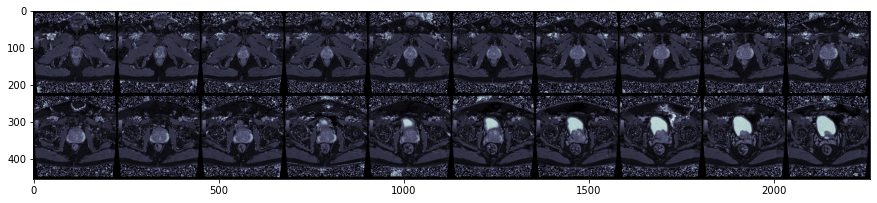

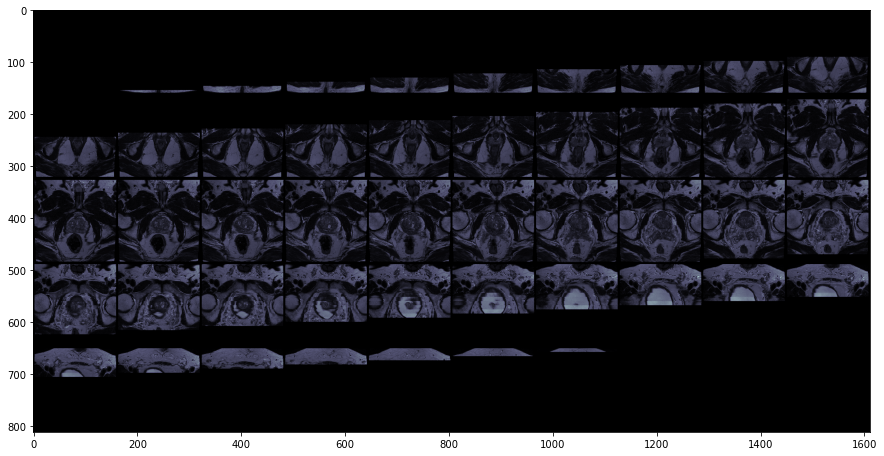

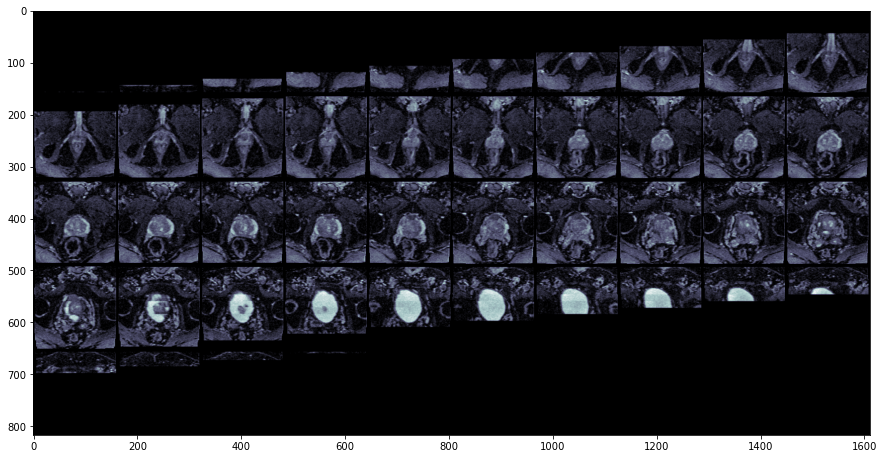

In [45]:
t1_rescaled.show()
t2_rescaled.show()
adc_rescaled.show()

### Pad to uniform size
The T1 map had the larges FOV in all planes. As T2 and ADC were scaled to match in pixel spacing, they now have smaller size of the pixel array. Zero-padding can scale the images to a uniform size. Not in all cases, one sequence might occupy the largest area of space in all three dimensions. So padding has to be calculated for each axis. 

In [46]:
t1_rescaled.get_origin_px_id(), t1_rescaled.size()

((18, 144, 101), (20, 224, 224))

From the size of the T1 map and the px ID of the origin, one can calculate the maximum distance between image border and origin.  
For the D-axis:  
`d_start = 19`, `d_end = 20-19=1`

In [47]:
t2_rescaled.get_origin_px_id(), t2_rescaled.size()

((31, 119, 71), (48, 160, 159))

T2 seems to occupy a larger space in cranio caudal direction (D-dimension).  
`d_start = 20`, `d_end = 24-20=4`

In [48]:
adc_rescaled.get_origin_px_id(), adc_rescaled.size()

((34, 121, 70), (44, 161, 159))

ADC and T2 seem to occupy the equal space in cranio caudal direction. So, some slices need to be padded to T1. 
One slice at the start of the volume (`d_start_t2 - d_start_t1`) and three at the end of the volume. 

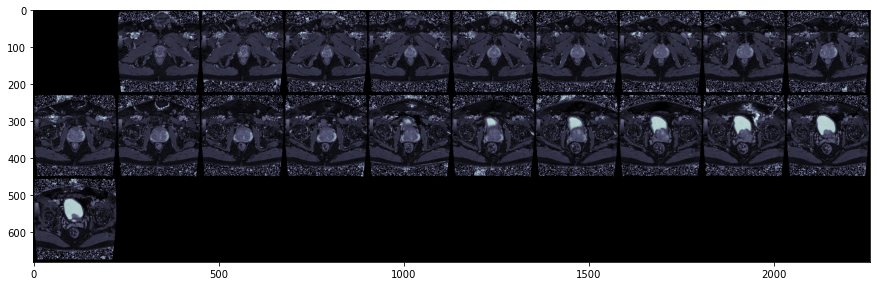

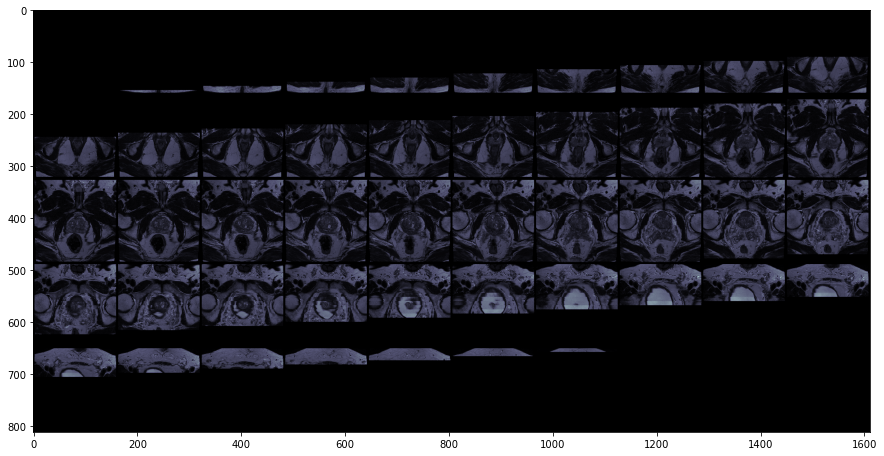

In [49]:
F.pad(t1_rescaled, (0,0,0,0,1,3)).show()
t2_rescaled.show()

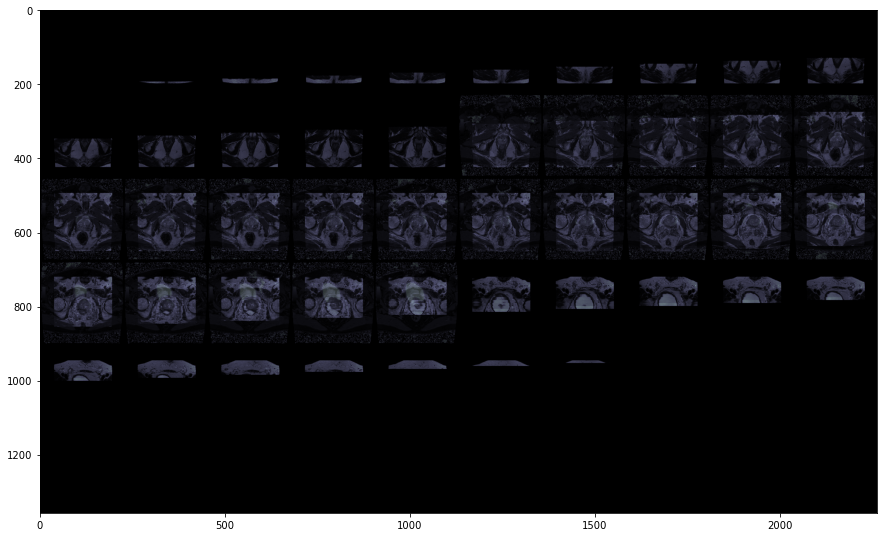

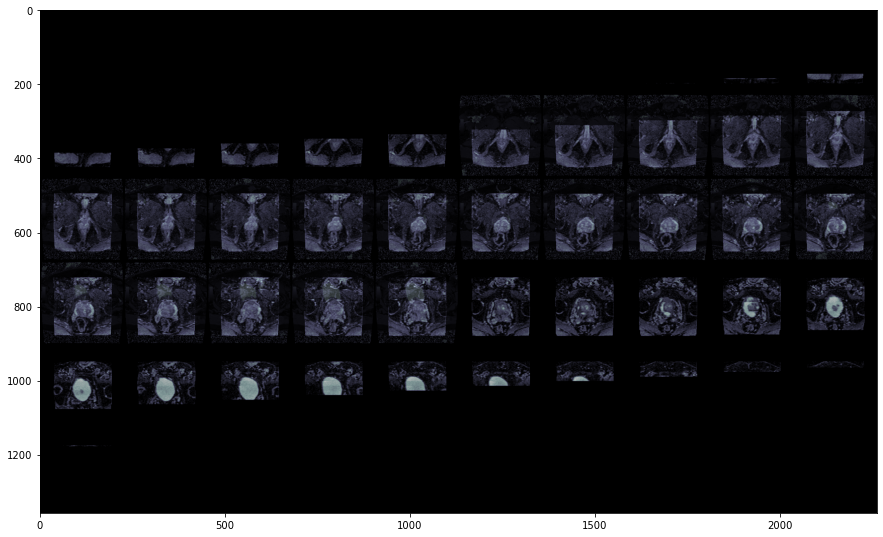

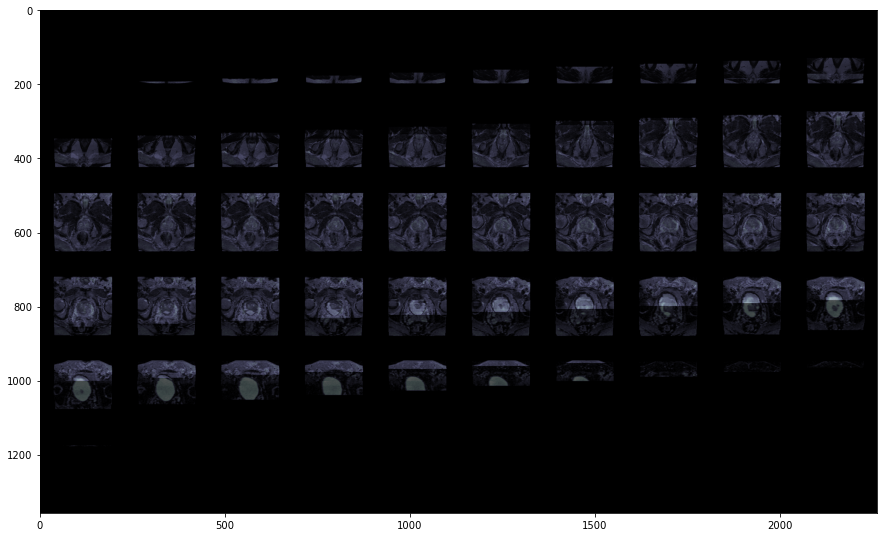

In [51]:
items = [t1_rescaled, t2_rescaled, adc_rescaled]
dist_start_to_orig = torch.stack([tensor(item.get_origin_px_id()) for item in items])
f = lambda x: tuple(map(operator.sub, x.size(), x.get_origin_px_id()))
dist_orig_to_end = torch.stack([tensor(f(item)) for item in items])
pad_start = dist_start_to_orig.max(0)[0] - dist_start_to_orig
pad_end = dist_orig_to_end.max(0)[0] - dist_orig_to_end
pad = torch.stack((pad_start, pad_end), dim=2).view(3,6)

for i in range(0, len(items)):
    p = tuple(int(x) for x in pad[i])
    items[i] = F.pad(items[i], p[::-1])
    
t1_pad, t2_pad, adc_pad = items

t1_pad.show()
t2_pad.show(add_to_existing=True, alpha = 0.75)

t1_pad.show()
adc_pad.show(add_to_existing=True, alpha = 0.75)

t2_pad.show()
adc_pad.show(add_to_existing=True, alpha = 0.35)

From the images above, ist seems, as the registration worked, as pixels of the same physical space are now also in the same image area. 

In [ ]:
def pad_sequences(sequences:list):
    "padds a list of 3D sequences to a uniform size, while maintaining the position of the physical origin"
    
    # to get the maximum distance for each dimension, first the distances are calulated for each 
    # item, then stacked to a 3 x n tenosor (n = number of items) and the maximum value of each colum
    # is selected. 
    dist_start_to_orig = torch.stack([tensor(item.get_origin_px_id()) for item in sequences])
    get_dist_orig_to_end = lambda x: tuple(map(operator.sub, x.size(), x.get_origin_px_id()))
    dist_orig_to_end = torch.stack([tensor(get_dist_orig_to_end(item)) for item in sequences])
    
    # calculate the px to pad for each volume
    pad_start = dist_start_to_orig.max(0)[0] - dist_start_to_orig
    pad_end = dist_orig_to_end.max(0)[0] - dist_orig_to_end
    # interleave the two tensors
    pad = torch.stack((pad_start, pad_end), dim=2).view(3,6)

    for i in range(0, len(sequences)):
        p = tuple(int(x) for x in pad[i])
        sequences[i] = F.pad(sequences[i], p[::-1])
        
    return sequences

## Warp it up

In [ ]:
dcm_t1.round()

In [ ]:
torch.eye(3,3)

In [ ]:

dcm_t2 = tensor(t2.get_direction()).view(3,3)
t2_angles = angle_from_dcm(dcm_t2)
to_rotate = tuple(map(operator.sub, t1_angles, t2_angles))
to_rotate
@patch
def rotate_3d_volume(x:(TensorDicom3D, TensorMask3D), angles_to_rotate):
    # angles are in order W, H, D
    # Tensor axis are D, H, W
    
    m = x._metadata
    sp_w, sp_h, sp_d = x.get_spacing()
    
    px_sz = x.get_spacing()[0]
    
    f = lambda a,b: a/b if b > 1 else a*b
    
    angles_to_rotate = tuple(map(f, angles_to_rotate, (sp_w, sp_h, sp_d)))
    angles_to_rotate = tuple(map(f, angles_to_rotate, (sp_h, sp_d, sp_w, )))
    
    x = x.apply_along_dim(partial(rotate, angle = angles_to_rotate[2], expand=True),dim=2)
    x = x.apply_along_dim(partial(rotate, angle = angles_to_rotate[1], expand=True),dim=1)
    x = x.apply_along_dim(partial(rotate, angle = angles_to_rotate[0], expand=True),dim=0)
    
    x._metadata = m
    return x

In [ ]:
class CrudeImageRegistration(object):
    
    'takes in sequences from an examination and returns images and matches them according to the image spacing and origin'
    def __init__(self):
        pass
    
    def __call__(self, sequences):
        sequences = self.rescale_sequences(sequences)
        
        
        
        
        
        sequences = self.pad_sequences(sequences)
        return sequences 
    
    def rescale_sequences(self, sequences:list):
        w_sp, h_sp, d_sp = [],[],[]
        for item in sequences:
            w,h,d = item.get_spacing()
            w_sp.append(w)
            h_sp.append(h)
            d_sp.append(d)

        w_sp = max(w_sp)
        h_sp = max(h_sp)
        d_sp = max(d_sp)
        new_spacing = (w_sp, h_sp, d_sp)
        sequences = [item.resize_3d(self.calc_new_size(item, new_spacing)) for item in sequences]
        return sequences
    
    def pad_sequences(self, sequences:list):
        'padds a list of 3D sequences to a uniform size, while maintaining the position of the physical origin'
    
        # to get the maximum distance for each dimension, first the distances are calulated for each 
        # item, then stacked to a 3 x n tenosor (n = number of items) and the maximum value of each colum
        # is selected. 
        dist_start_to_orig = torch.stack([tensor(self.get_origin_px_id(item)) for item in sequences])
        get_dist_orig_to_end = lambda x: tuple(map(operator.sub, x.size(), self.get_origin_px_id(x)))
        dist_orig_to_end = torch.stack([tensor(get_dist_orig_to_end(item)) for item in sequences])

        # calculate the px to pad for each volume
        pad_start = dist_start_to_orig.max(0)[0] - dist_start_to_orig
        pad_end = dist_orig_to_end.max(0)[0] - dist_orig_to_end
        # interleave the two tensors
        
        pad = torch.stack((pad_start, pad_end), dim=2).view(len(sequences),6)

        for i in range(0, len(sequences)):
            p = tuple(int(x) for x in pad[i])
            sequences[i] = F.pad(sequences[i], p[::-1])

        return sequences
    
    def get_origin_px_id(self, x): 
        D,H,W = x.size()
        w,h,d = tuple(map(lambda a,b: int(round(a/b))*-1, x.get_origin(), x.get_spacing()))
        return d,H-h,w
    
    def calc_new_size(self, x, new_spacing):        
        rescale_factor = tuple(map(operator.truediv, x.get_spacing(), new_spacing))
        new_size = tuple(map(operator.mul, x.size(), rescale_factor[::-1]))
        new_size = tuple([int(round(x)) for x in new_size])
        return new_size

In [ ]:
path = Path('/media/ScaleOut/prostata/data/dcm/A0040687294')

t1 = TensorDicom3D.create(path/'T1_map/DICOM')
t2 = TensorDicom3D.create(path/'T2/DICOM')
adc = TensorDicom3D.create(path/'ADC/DICOM')


t1, t2, adc, = CrudeImageRegistration()([t1, t2, adc])

In [ ]:
t1.get_direction(), t2.get_direction()

In [ ]:
t1.show()
t2.show(add_to_existing=True, alpha = 0.75)

t1.show()
adc.show(add_to_existing=True, alpha = 0.25)

t2.show()
adc.show(add_to_existing=True, alpha = 0.25)